### Final Code for Sex differences project 

### 1. Prep data set 

In [1]:
%matplotlib inline
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

import pandas as pd
import seaborn as sns; sns.set()
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from pathlib import Path


from nilearn import plotting,image 
from sklearn.metrics import confusion_matrix


In [85]:
#import data set
df = pd.read_csv("/home/xlajoie/Desktop/unrestricted_original.csv")

In [86]:
# Filter left-handers (>=50 handedness) 
df = df[df["Handedness"] >= 50].reset_index()


In [87]:
# transform M and F with 0 and 1 

df.rename(columns={"Subject": "subject_label"}, inplace=True)
df["Gender"] = df["Gender"].replace({"M": 0, "F": 1})
df

,index,subject_label,Release,Acquisition,Gender,Age_in_Yrs,Race,Ethnicity,Handedness,Education,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,S900,Q11,0,27,White,Not Hispanic/Latino,65,16.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,S900,Q08,0,27,White,Not Hispanic/Latino,85,16.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,S500,Q06,1,35,Black or African Am.,Not Hispanic/Latino,90,12.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,S500,Q06,0,24,White,Hispanic/Latino,80,12.0,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,S900,Q10,0,30,White,Not Hispanic/Latino,50,14.0,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,662,990366,S900,Q10,0,22,White,Not Hispanic/Latino,95,15.0,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
560,663,991267,S500,Q06,0,30,White,Not Hispanic/Latino,75,14.0,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
561,664,992673,S900,Q12,1,33,White,Not Hispanic/Latino,70,14.0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
562,665,993675,S900,Q09,1,29,White,Not Hispanic/Latino,85,16.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [88]:
print(df['Gender'].value_counts()[0])
print(df['Gender'].value_counts()[1])

263
301


In [89]:
#save new csv with modifications as "final hcp database"
df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [90]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [91]:
df["Gender"]  # should have the whole list

0      0
1      0
2      1
3      0
4      0
      ..
559    0
560    0
561    1
562    1
563    1
Name: Gender, Length: 564, dtype: int64

In [72]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 

atlas_aal = datasets.fetch_atlas_aal()
masker = NiftiLabelsMasker(atlas_aal.maps) #si masker niftimasker MNI = devient tout les voxels 

def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1)
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn


In [73]:
print(len(atlas_aal.labels))

116


In [74]:
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer

x_correl = []
nb_subjects = len(df)
subject_label = df["subject_label"][:nb_subjects]

for sub in tqdm(subject_label):
    img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
    x_correl.append(img4d2vector(img_path, masker))

x_correl = np.array(x_correl)
x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 

100%|█████████████████████████████████████████| 564/564 [06:14<00:00,  1.51it/s]


(564, 928)

In [75]:
# prendre sex et le mettre dans une liste

y_sex = df["Gender"][:nb_subjects]  # maybe list(df["Gender"]) 


In [76]:
print(sum(y_sex), len(y_sex))  #double check 

301 564


#### 2. Classifier 

In [77]:
# split the sample o training/test with a 80/20 % ratio 
# and stratify sex by class, also shuffle the data

X_train, X_test, y_train, y_test = train_test_split( 
                                                    x_correl,  # x 
                                                    y_sex,       # y 
                                                    test_size = 0.2, # 80%/20% split 
                                                    shuffle = True,  #shuffle dataset before splitting
                                                    stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                    random_state = 123) #same shuffle each time 

print('train:', len(X_train),'test:', len(X_test))

train: 451 test: 113


In [78]:
score = []

model = LinearSVC()

#score = cross_val_score(model, X_train, y_train, cv=10)
score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())
print(score)

[0.7006763285024155]


In [79]:
model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df_result = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df_result.head())

# print results
print('accuracy (r2) =', acc)

       Positive  Negative
True         37        16
False         8        52
accuracy (r2) = 0.7876106194690266


Text(0, 0.5, 'weight')

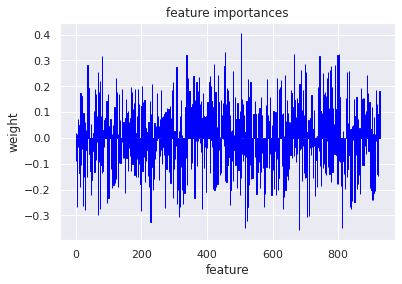

In [80]:
coef = model.coef_[0]

plt.bar(range(model.coef_.shape[-1]),model.coef_[0], edgecolor = "blue" )
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')



In [81]:
#coef_image = vector2img4d(np.abs(coef),masker) 
coef_image = vector2img4d(coef,masker) 

coef_image

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


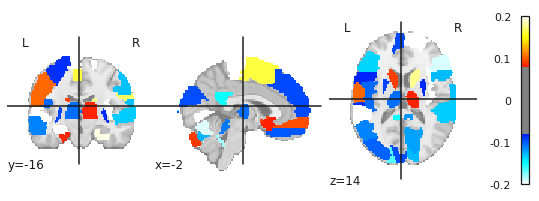

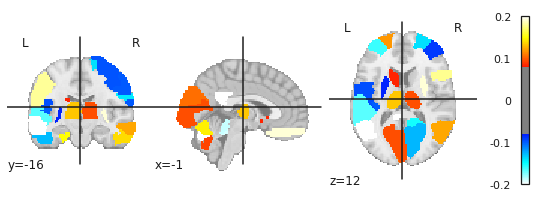

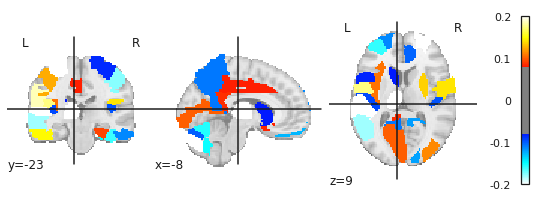

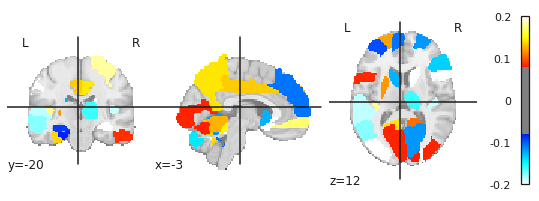

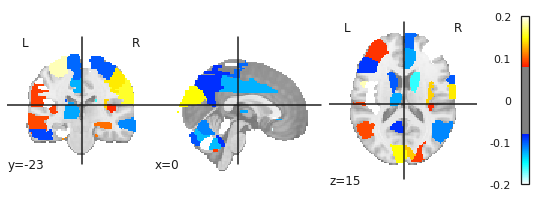

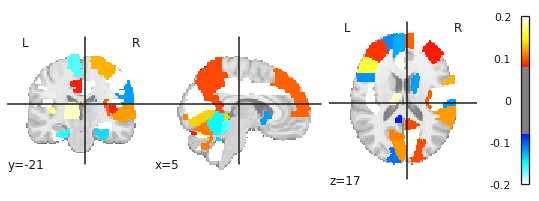

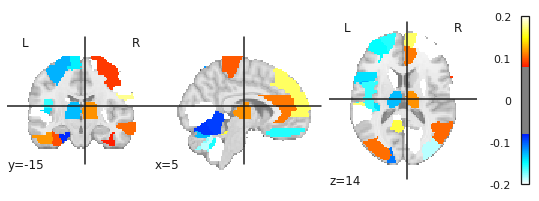

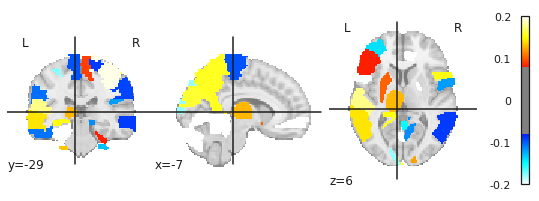

In [82]:

for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    plotting.plot_stat_map(img,
                           threshold=0.08, vmax= 0.2
                           #display_mode="z", cut_coords=1,
                           #colorbar=False,
                          )


### Essai avec PCA and best n components

Le x_correl est la meme que celui utilise pour le model avec les masker, il faut modifier le code en-dessous pour aller chercher un autre x_correl.

In [57]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker("/data/brambati/local/Core/fsl/6.0.4/data/standard/MNI152_T1_2mm_brain_mask.nii.gz") #si masker niftimasker MNI = devient tout les voxels

img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer

x_correl = []
nb_subjects = 10
subject_label = df["subject_label"][:nb_subjects]

for sub in tqdm(subject_label):
    img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
    x_correl.append(img4d2vector(img_path, masker))

x_correl = np.array(x_correl)
x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.54it/s]


(10, 1827864)

In [58]:
x_correl.shape

(10, 1827864)

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameter (CV score=0.600):


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


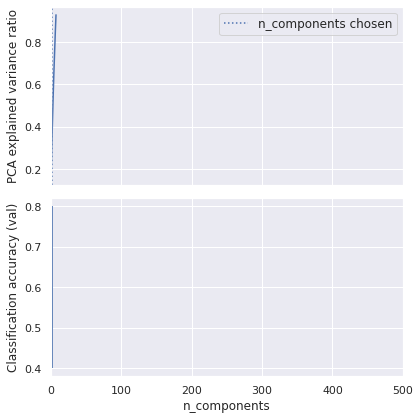

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of

In [121]:
# code comes from : https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# pca.explained_variance_ratio_ = [0.8, 0.85,0.9]
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
svc = LinearSVC()
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("prediction", svc)])


# max_feature = int(0.9*len(x_correl))
# n_components_range = range(0, max_feature, 10) # A range of different values for n_components

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [0.8, 0.85, 0.9],           # would be better to specify a % of variance explained, so like 90%  [0.8, 0.85. 0.9 ]  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    "prediction__C": np.logspace(-4, 4, 4),                    # If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)             # here we didnt specify a CV number so  None= 5 twhich is the default cross-val number with a 80`20 split, PCA sur le train set which is 160 
search.fit(x_correl, y_sex)
print("Best parameter (CV score=%0.3f):" % search.best_score_)


# Plot the PCA spectrum
pca.fit(x_correl)

#pipe.fit(x_correl)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
#ax0.plot(
#    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
#)
ax0.plot(np.cumsum(search.best_estimator_[1].explained_variance_ratio_))
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(0, 500)

plt.tight_layout()
plt.show()


In [118]:
print(search.best_estimator_[1].explained_variance_ratio_)

[0.163059   0.13864185 0.12602925 0.12020166 0.10756207 0.09524196
 0.09376632 0.08446417]


In [235]:
if best_ncomp == 0:
    model = LinearSVC(max_iter=2000)
else:
    model = Pipeline([
            ('feature_selection', PCA(best_ncomp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])

model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df.head())

# print results
print('accuracy (r2) =', acc)

# coef= model.coef_[0]
# coef_reshape = np.reshape(coef, (8, 193369))
# coef_reshape

       Positive  Negative
True         16         3
False         4        17
accuracy (r2) = 0.825


# Essais brainnetome atlas

In [112]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 

atlas_brain = "/data/brambati/local/Core/brainnetome/2020-05-18/BN_Atlas_274_combined.nii.gz"
masker = NiftiLabelsMasker(atlas_brain) #si masker niftimasker MNI = devient tout les voxels 

def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1)
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn


In [113]:
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer

x_correl = []
nb_subjects = len(df)
subject_label = df["subject_label"][:nb_subjects]

for sub in tqdm(subject_label):
    img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
    x_correl.append(img4d2vector(img_path, masker))

x_correl = np.array(x_correl)
x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 

100%|█████████████████████████████████████████| 564/564 [08:29<00:00,  1.11it/s]


(564, 2192)

In [114]:
print(masker.labels)

None


In [115]:
# prendre sex et le mettre dans une liste

y_sex = df["Gender"][:nb_subjects]  # maybe list(df["Gender"]) 


In [116]:
# split the sample o training/test with a 80/20 % ratio 
# and stratify sex by class, also shuffle the data

X_train, X_test, y_train, y_test = train_test_split( 
                                                    x_correl,  # x 
                                                    y_sex,       # y 
                                                    test_size = 0.2, # 80%/20% split 
                                                    shuffle = True,  #shuffle dataset before splitting
                                                    stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                    random_state = 123) #same shuffle each time 

print('train:', len(X_train),'test:', len(X_test))

train: 451 test: 113


In [117]:
score = []

model = LinearSVC()

#score = cross_val_score(model, X_train, y_train, cv=10)
score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())
print(score)

[0.7538164251207728]


In [118]:
model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df_results = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df_results.head())

# print results
print('accuracy (r2) =', acc)

       Positive  Negative
True         40        13
False        11        49
accuracy (r2) = 0.7876106194690266


Text(0, 0.5, 'weight')

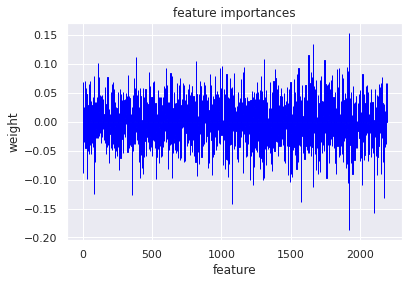

In [119]:
coef = model.coef_[0]

plt.bar(range(model.coef_.shape[-1]),model.coef_[0], edgecolor = "blue" )
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')



In [122]:
#coef_image = vector2img4d(np.abs(coef),masker) 
coef_image = vector2img4d(coef,masker) 

coef_image

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 8)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91   8   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code  

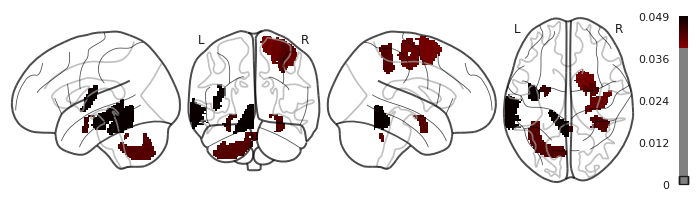

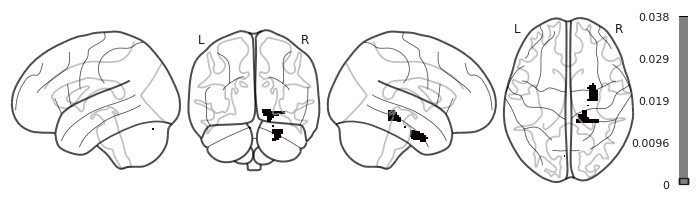

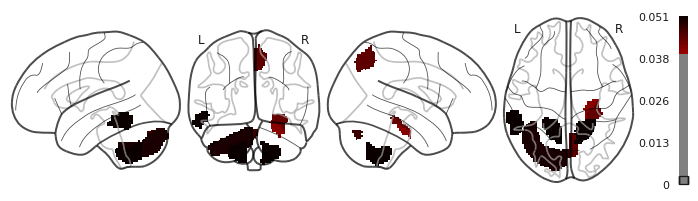

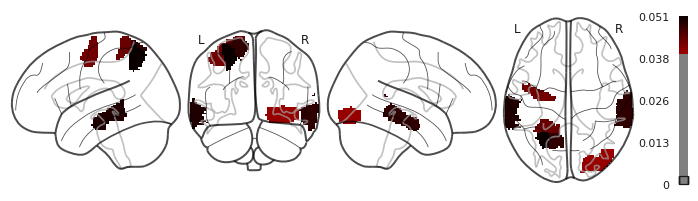

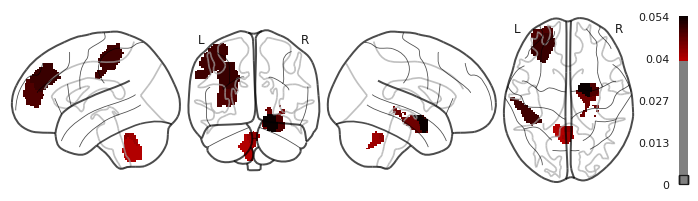

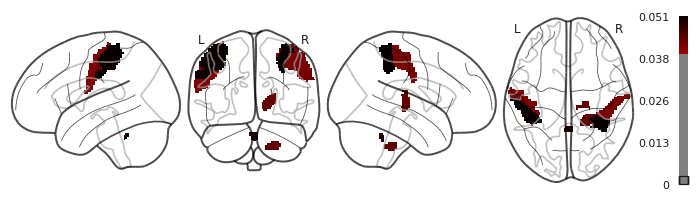

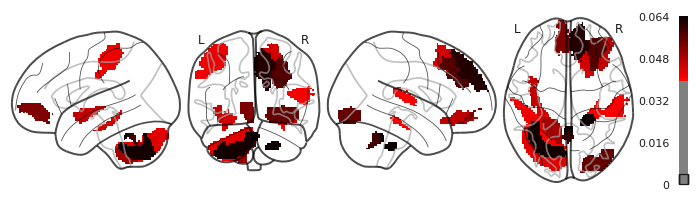

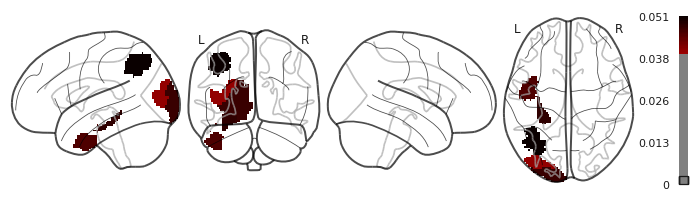

In [49]:

for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    plotting.plot_glass_brain(img,display_mode = "lyrz", threshold = 0.04,colorbar=True ) 


# Atlas Destrieux

In [123]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 

atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [124]:
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer

x_correl = []
nb_subjects = len(df)
subject_label = df["subject_label"][:nb_subjects]

for sub in tqdm(subject_label):
    img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
    x_correl.append(img4d2vector(img_path, masker))

x_correl = np.array(x_correl)
x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 

100%|█████████████████████████████████████████| 564/564 [07:09<00:00,  1.31it/s]


(564, 1184)

In [125]:
# prendre sex et le mettre dans une liste

y_sex = df["Gender"][:nb_subjects]  # maybe list(df["Gender"]) 


In [126]:
print(sum(y_sex), len(y_sex))  #double check 

301 564


In [127]:
model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df_result = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df_result.head())

# print results
print('accuracy (r2) =', acc)

       Positive  Negative
True         40        13
False        11        49
accuracy (r2) = 0.7876106194690266


Text(0, 0.5, 'weight')

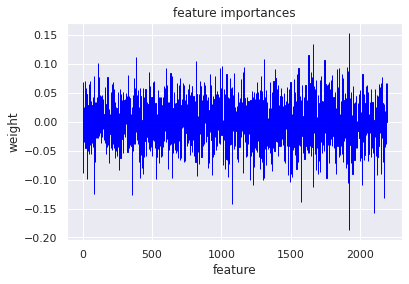

In [128]:
coef = model.coef_[0]

plt.bar(range(model.coef_.shape[-1]),model.coef_[0], edgecolor = "blue" )
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')



928


In [129]:
#coef_image = vector2img4d(np.abs(coef),masker) 
coef_image = vector2img4d(coef,masker) 

coef_image

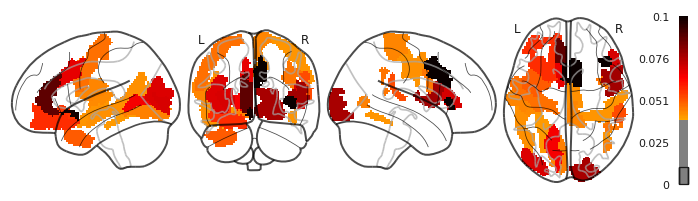

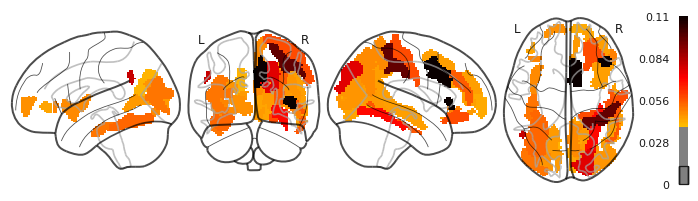

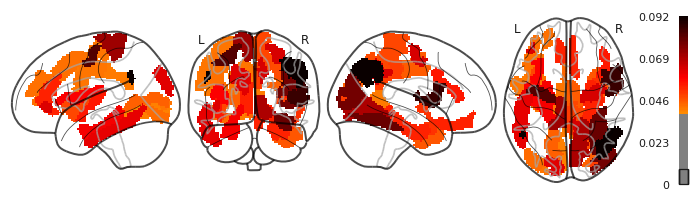

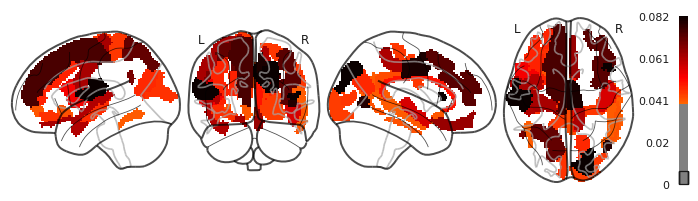

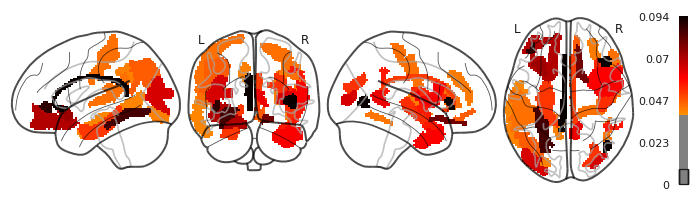

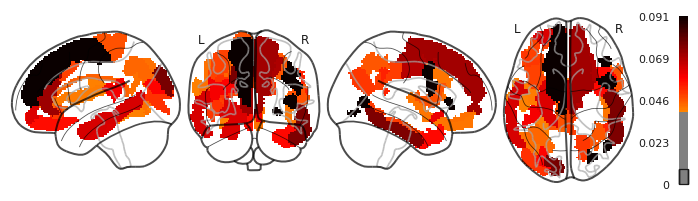

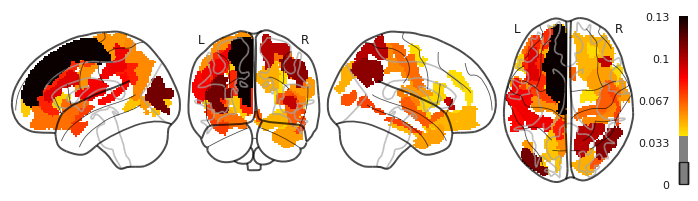

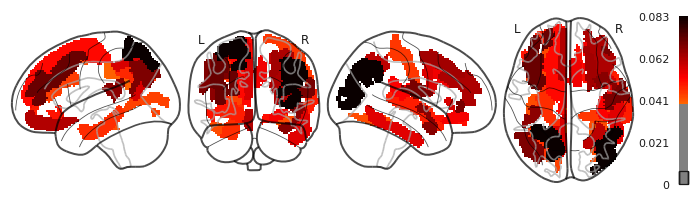

In [130]:

for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    plotting.plot_glass_brain(img,display_mode = "lyrz", threshold = 0.04,colorbar=True ) 
